In [1]:
from pprint import pprint
from collections import Counter

import pandas as pd
import numpy as np
import scipy

import os

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

from natsort import natsorted

from IPython.display import display, HTML
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

## Data:

In [4]:
df_train = pd.read_csv('../input/train2016.csv')
df_test = pd.read_csv('../input/test2016.csv')

party_encoder = LabelEncoder()
df_train.Party = party_encoder.fit_transform(df_train.Party)

TRAIN = 0
TEST = 1

df_train['source'] = TRAIN
df_test['source'] = TEST

df_all = pd.concat([df_train, df_test])

describe = df_all.YOB.describe(percentiles=[0.01, 0.99])
low = describe['1%']
high = describe['99%']

df_all.loc[(df_all.YOB < low) | (df_all.YOB > high), 'YOB'] = np.nan
df_all.loc[df_all.YOB.isnull(), 'YOB'] = df_all.YOB.median()

age = 2016 - df_all.YOB
bins = [0, 19, 29, 39, 49, 59, 100]
labels = [('%d-%d') % (bins[i], bins[i + 1]) for i in range(len(bins) - 1)]
df_all['Age'] = pd.cut(age, bins=bins, labels=labels).astype(str)

In [6]:
all_columns = sorted(set(df_all.columns) - {'USER_ID', 'Party', 'source'})

categorical = [col for col in all_columns if df_all[col].dtype == 'O']
demographic = [col for col in categorical if not col.startswith('Q')]
questions   = natsorted([q for q in categorical if q.startswith('Q')])
numerical   = [col for col in all_columns if df_all[col].dtype != 'O']

df_all.loc[:, categorical] = df_all.loc[:, categorical].fillna('na')

for c in categorical:
    df_all[c] = df_all[c].str.lower()
    
def clean_level_names(s):
    s = s.replace('$', '')
    s = s.replace(',', '')
    s = s.replace(' - ', '_')
    s = s.replace(' ', '_')
    return s

df_all.Income = df_all.Income.apply(clean_level_names)
df_all.HouseholdStatus = df_all.HouseholdStatus.str.replace(' ', '_')
df_all.EducationLevel = df_all.EducationLevel.str.replace(' ', '_')
df_all.Q117193 = df_all.Q117193.str.replace(' ', '_')
df_all.Q120194 = df_all.Q120194.str.replace(' ', '_')

df_all.Q98059  = df_all.Q98059.map({'yes': 'yes', 'only-child': 'no', 'na': 'na'})
df_all.Q99982  = df_all.Q99982.map({'check!': 'yes', 'nope': 'no', 'na': 'na'})
df_all.Q106997 = df_all.Q106997.map({'yay people!': 'yes', 'grrr people': 'no', 'na': 'na'})
df_all.Q108855 = df_all.Q108855.map({'yes!': 'yes', 'umm...': 'no', 'na': 'na'})
df_all.Q117186 = df_all.Q117186.map({'hot headed': 'yes', 'cool headed': 'no', 'na': 'na'})

In [7]:
if os.path.exists('questions_selected.csv'):
    df_questions = pd.read_csv('questions_selected.csv', index_col='Question ID')
else:
    df_questions = pd.read_excel('../input/Questions.xlsx')
    df_questions['Question ID'] = 'Q' + df_questions['Question ID'].astype(str)
    df_questions.set_index('Question ID', inplace=1)
    df_questions['selected'] = False

In [8]:
yes_no = set(df_questions[df_questions['Possible Answers'] == 'Yes,No'].index) 
yes_no = natsorted(yes_no | {'Q98059', 'Q99982', 'Q106997', 'Q108855', 'Q117186'})

answers_cnt = df_all[yes_no].apply(Counter, axis=1).apply(pd.Series).fillna(0)
answers_cnt.columns = ['%s_cnt' % c for c in answers_cnt.columns]

In [9]:
train_idx = (df_all.source == TRAIN).values
df_train = df_all[df_all.source == TRAIN]
y = df_train.Party

In [10]:
total_mean = y.mean()

def retrain(*args):
    selected_questions = list(df_questions[df_questions.selected].index)
    records = df_all[demographic + selected_questions].to_dict(orient='records')
    oh_vectorizer = DictVectorizer(separator='_',)
    oh = oh_vectorizer.fit_transform(records)

    X = scipy.sparse.hstack([oh[train_idx], answers_cnt[df_all.source == TRAIN]])
    
    lr = LinearSVC(penalty='l1', dual=False)
    params = {'C': [0.05, 0.1, 0.5, 0.7, 1]}
    grid = GridSearchCV(lr, params, scoring='accuracy', n_jobs=-1, verbose=0, )
    grid.fit(X, y)

    print 'selected questions:', ', '.join(selected_questions)
    print 'best accuracy: %0.5f (C=%f)' % (grid.best_score_, grid.best_params_['C'])
    js = '<script>console.log(%0.5f);</script>' % (grid.best_score_)
    display(HTML(js))

def save_change(args):
    if args['name'] != 'value':
        return
    qid = args['owner'].idx
    df_questions.loc[qid, 'selected'] = args['new']
    retrain()

for idx, row in df_questions.iterrows():
    checkbox = widgets.Checkbox(value=row.selected, idx=idx)
    checkbox.observe(save_change)

    series = df_train[idx].astype(str).fillna('NA')
    d = (total_mean - df_train.Party.groupby(series).mean()).to_dict()
    mtv = ['%s: %0.3f' % (k, v) for (k, v) in d.items()]

    text = widgets.HTML(idx + ': ' + row['Question Text'] + ' ' + ', '.join(mtv))
    display(widgets.HBox((checkbox, text)))

button = widgets.Button()
button.description = 'Recalculate'
button.on_click(retrain)
display(button)

retrain()

selected questions: Q98059, Q98197, Q98869, Q99480, Q106272, Q107869, Q108343, Q108617, Q108754, Q109244, Q109367, Q112270, Q113181, Q114386, Q115195, Q115611, Q116881, Q116953, Q120650, Q122771, Q123621, Q124122
best accuracy: 0.63775 (C=0.050000)


In [11]:
df_questions.to_csv('questions_selected.csv')

In [12]:
sel = df_questions[df_questions.selected]
for i, q in zip(sel.index, sel['Question Text']):
    print '- (%s) %s' % (i, q)

- (Q98059) Do/did you have any siblings?
- (Q98197) Do you pray or meditate on a regular basis?
- (Q98869) Does life have a purpose?
- (Q99480) Did your parents spank you as a form of discipline/punishment?
- (Q106272) Do you own any power tools? (power saws, drills, etc.)
- (Q107869) Do you feel like you're "normal"?
- (Q108343) Do you feel like you have too much personal financial debt?
- (Q108617) Do you live in a single-parent household?
- (Q108754) Do both of your parents have college degrees?
- (Q109244) Are you a feminist?
- (Q109367) Have you ever been poor (however you personally defined it at the time)?
- (Q112270) Are you better looking than your best friend?
- (Q113181) Do you meditate or pray on a regular basis?
- (Q114386) Are you more likely to over-share or under-share?
- (Q115195) Do you live within 20 miles of a major metropolitan area?
- (Q115611) Do you personally own a gun?
- (Q116881) Would you rather be happy or right?
- (Q116953) Do you like rules?
- (Q120650) W

In [13]:
selected_questions = list(df_questions[df_questions.selected].index)
records = df_all[demographic + selected_questions].to_dict(orient='records')
oh_vectorizer = DictVectorizer(separator='_')
oh = oh_vectorizer.fit_transform(records)

X = scipy.sparse.hstack([oh[train_idx], answers_cnt[df_all.source == TRAIN]])

In [14]:
features = oh_vectorizer.get_feature_names() + list(answers_cnt.columns)

In [15]:
lr = LinearSVC(penalty='l1', dual=False)
params = {'C': np.linspace(0.01, 1, num=101)}
grid = GridSearchCV(lr, params, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X, y)

Fitting 3 folds for each of 101 candidates, totalling 303 fits


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   40.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([ 0.01  ,  0.0199, ...,  0.9901,  1.    ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

In [16]:
grid.best_score_, grid.best_params_

(0.63757183908045978, {'C': 0.049599999999999998})

In [17]:
best_clf = grid.best_estimator_
names = np.array(features)
coeff = best_clf.coef_[0]
indices = coeff.argsort()

(-1, 101)

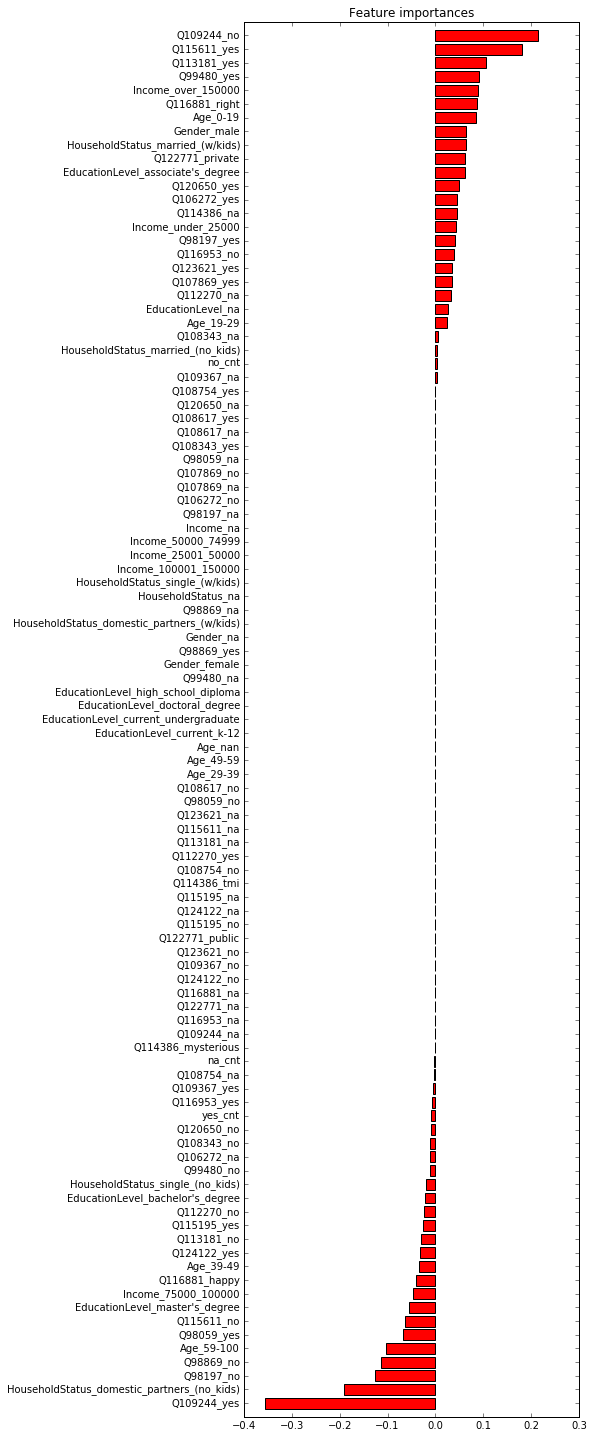

In [18]:
plt.figure(figsize=(6, 25))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), coeff[indices], color="r", align="center")

plt.yticks(range(X.shape[1]), names[indices])
plt.ylim([-1, X.shape[1]])

In [19]:
natsorted(names[coeff == 0])

['Age_29-39',
 'Age_49-59',
 'Age_nan',
 'EducationLevel_current_k-12',
 'EducationLevel_current_undergraduate',
 'EducationLevel_doctoral_degree',
 'EducationLevel_high_school_diploma',
 'Gender_female',
 'Gender_na',
 'HouseholdStatus_domestic_partners_(w/kids)',
 'HouseholdStatus_na',
 'HouseholdStatus_single_(w/kids)',
 'Income_25001_50000',
 'Income_50000_74999',
 'Income_100001_150000',
 'Income_na',
 'Q98059_na',
 'Q98059_no',
 'Q98197_na',
 'Q98869_na',
 'Q98869_yes',
 'Q99480_na',
 'Q106272_no',
 'Q107869_na',
 'Q107869_no',
 'Q108343_yes',
 'Q108617_na',
 'Q108617_no',
 'Q108617_yes',
 'Q108754_no',
 'Q109244_na',
 'Q109367_no',
 'Q112270_yes',
 'Q113181_na',
 'Q114386_mysterious',
 'Q114386_tmi',
 'Q115195_na',
 'Q115195_no',
 'Q115611_na',
 'Q116881_na',
 'Q116953_na',
 'Q120650_na',
 'Q122771_na',
 'Q122771_public',
 'Q123621_na',
 'Q123621_no',
 'Q124122_na',
 'Q124122_no']

## Submission

In [20]:
test_idx = (df_all.source == TEST).values
X_test = scipy.sparse.hstack([oh[test_idx], answers_cnt[df_all.source == TEST]])

y_pred = grid.predict(X_test).astype(int)
y_pred = party_encoder.inverse_transform(y_pred)

In [21]:
user_ids = df_test.USER_ID.values

result = pd.DataFrame({'USER_ID': user_ids, 'Predictions': y_pred})
result.to_csv('svm10.csv', index=False)